In [16]:
import numpy as np
import matplotlib.pyplot as plt
import Global_tomerge as global_nav
import Global_display_functions as plt_glob
from IPython.display import Image
import matplotlib.image as mpimg
import math
import random

Setting Parameters to display

In [17]:
# object_corners = [[(53, 107), (107, 107), (107, 53), (53, 53)],
#                   [(120, 200), (200, 280), (280, 200), (200, 120)],
#                   [(243, 87), (297, 87), (297, 33), (243, 33)]]
#object_corners = global_nav.create_dictionnary(object_corners)
# robot = (50,15)
# goal = (255, 250)
# RandG = global_nav.create_RandG_dict(robot, goal)
object_corners= {'object_1': [(17.821782178217823, 80.86021505376344), (3.7128712871287126, 80.86021505376344), (3.7128712871287126, 90.3225806451613), (17.821782178217823, 90.3225806451613)], 'object_2': [(20.04950495049505, 20.43010752688172), (7.425742574257425, 20.43010752688172), (7.425742574257425, 28.602150537634408), (20.04950495049505, 28.602150537634408)], 'object_3': [(40.59405940594059, 47.31182795698925), (21.78217821782178, 47.31182795698925), (21.78217821782178, 61.72043010752688), (40.59405940594059, 61.72043010752688)], 'object_4': [(68.81188118811882, 9.67741935483871), (52.227722772277225, 9.67741935483871), (52.227722772277225, 26.451612903225808), (68.81188118811882, 26.451612903225808)], 'object_5': [(69.3069306930693, 73.97849462365592), (58.415841584158414, 73.97849462365592), (58.415841584158414, 85.3763440860215), (69.3069306930693, 85.3763440860215)]}
RandG = {'robot': (15, 95), 'goal': (34.65346534653465, 7.956989247311828)}
robot_size = 12

The function grow obstacles is diffine for quadrilaterals since we had already decided to use only quadrilaterals as obstacles to ease the implementation. It takes the position of the oposite points and calculate the angle betweeen the points in order to find the values deltax and deltay that we should add to space the points by a value of half the robot size following the diagonal. Hence it will grow the obstacles to avoid collision. 
To add or remove the value deltax and deltay. I considered all the possibilities (case 1 to 4)

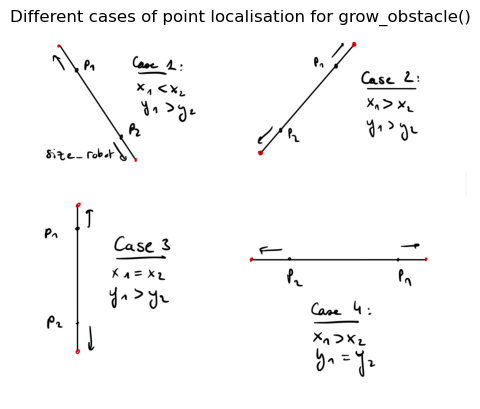

In [18]:
Image(filename='IMG_20CC1C4CB37F-1.jpeg')
img = mpimg.imread('IMG_20CC1C4CB37F-1.jpeg')
plt.imshow(img)
plt.axis('off')
plt.title('Different cases of point localisation for grow_obstacle()') 
plt.show()


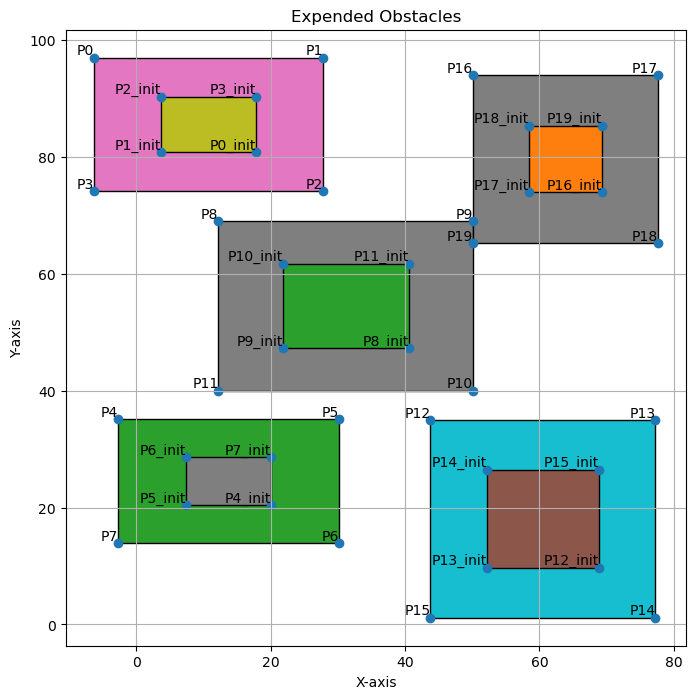

In [19]:
expended_corners = global_nav.grow_obstacles(object_corners, robot_size)
plt_glob.plot_expended_obstacles(object_corners, RandG, expended_corners)

We chose a map with printed obstacles. Thus these obstacles are seen only from top camera and not the robot sensors since these obstacles need to be avoided using a global planning. Moreover we decided to use a map whithout a grid. Hence the obvious choice of algorithm for global path was the Dijkstra algorithm. Dijkstra's algorithm is more flexible than many other algorithm and doesn't rely on a grid structure. It is an algorithm that can adapt to various shapes of obstacle. Moreover, Dijkstra algorithm is known to be very efficient to work with weighted graph. In our context, the weights are the distances between the points. The algorithm is optimal since it guarantees to always find a solution that will minimize the distance for any point in the map. Moreover, the algorithm can become computationally heavy if the map is too big or there are too many obstacles, but it is then robust in our case where the map is small with relatively few connections.

First to create the adjacency list. We need to be able to find if two points are connected. I first needed to create a function that says if two segment lines intersect. To do so, I studied the theory about point orientation: (https://www.youtube.com/watch?v=wCR48FqkI4w ,https://www.geeksforgeeks.org/check-if-two-given-line-segments-intersect/) and created a function compute_orientation which returns the orientation of three given points. All points are defined as tuples corresponding to x and y coordinates. Then the intersect function finds if segments are connected, going through every case of orientation. 
The following plot is used to test the intersect function on 2 random segments: 

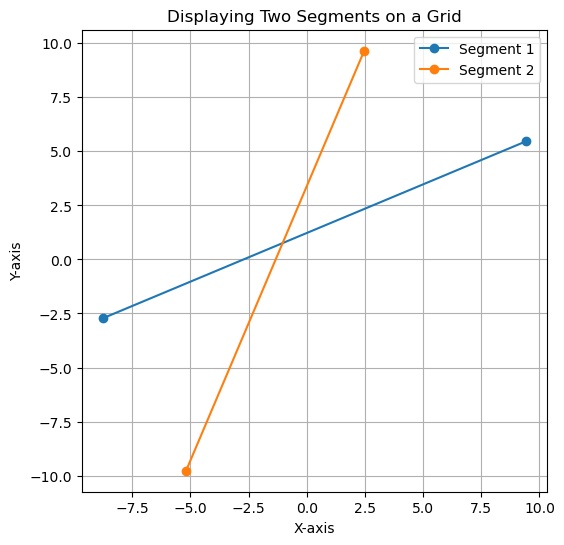

Are the segments crossing?  True


In [20]:
point1 = (random.uniform(-10, 10), random.uniform(-10, 10))
point2 = (random.uniform(-10, 10), random.uniform(-10, 10))
point3 = (random.uniform(-10, 10), random.uniform(-10, 10))
point4 = (random.uniform(-10, 10), random.uniform(-10, 10))
plt_glob.display_segments(point1, point2, point3, point4)
print("Are the segments crossing? ",global_nav.intersect (point1,point2,point3,point4))

Then using this. Two points are connected if we can draw a line between them without crossing any object segments. The function adjacency_list gows through every points and creates a new dictionnary saying which point is connected to which.

Robot inside obstacle
Robot inside obstacle
Robot inside obstacle
Robot inside obstacle
Robot inside obstacle
Robot inside obstacle
Robot inside obstacle
Robot inside obstacle


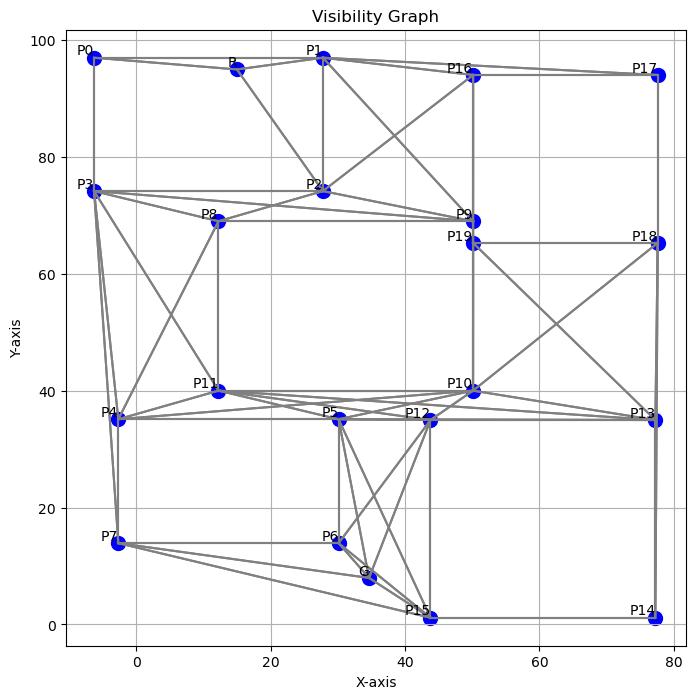

In [21]:
points_name2coord = global_nav.name2coord(expended_corners, RandG)
adjacent_list = global_nav.generate_adjacency_list(expended_corners, RandG, object_corners)
plt_glob.plot_visibility_graph(adjacent_list, points_name2coord)

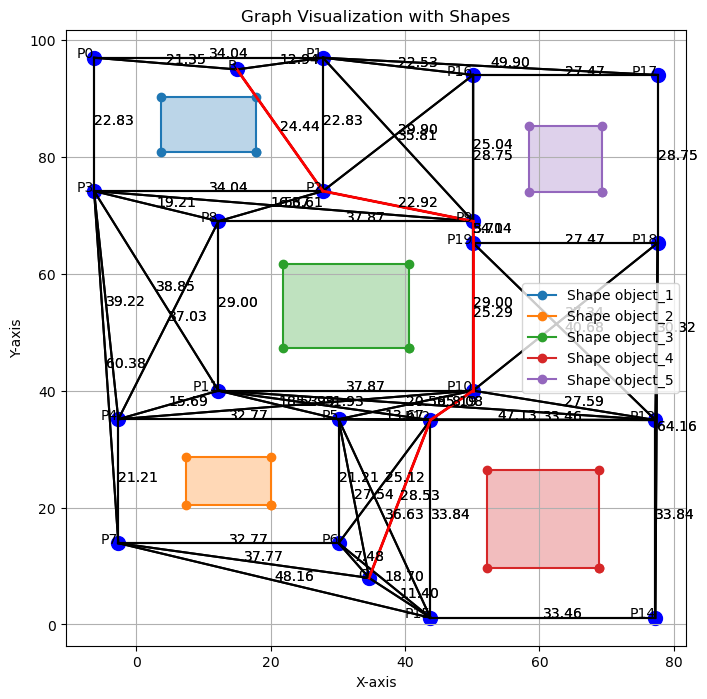

The shortest path is:  [(15, 95), (27.787951969837486, 74.17624470040252), (50.12071898298919, 69.01719358889505), (50.12071898298919, 40.01506447562107), (43.79091706397202, 34.98509457487125), (34.65346534653465, 7.956989247311828)]


In [22]:
distances = global_nav.calculate_distances(adjacent_list, points_name2coord)
shortest_path = global_nav.find_path(adjacent_list, points_name2coord)

path=[]
for name in shortest_path:
    path.append(points_name2coord[name], )


shortest_path = shortest_path.reverse()
plt_glob.plot_graph_with_shapes(adjacent_list, points_name2coord, distances, path, object_corners)
print("The shortest path is: ", path)

In [23]:
def is_point_inside_quad(point, quad_coords):
    x, y = point
    x_coords = [coord[0] for coord in quad_coords]
    y_coords = [coord[1] for coord in quad_coords]
    n = len(quad_coords)
    inside = False

    for i in range(n):
        j = (i + 1) % n
        if (
            ((y_coords[i] <= y and y < y_coords[j]) or (y_coords[j] <= y and y < y_coords[i])) and
            (x < (x_coords[j] - x_coords[i]) * (y - y_coords[i]) / (y_coords[j] - y_coords[i]) + x_coords[i])
        ):
            inside = not inside
    
    return inside

# Example coordinates of the quadrilateral
quad_coordinates = [(17.821782178217823, 80.86021505376344), (3.7128712871287126, 80.86021505376344), (3.7128712871287126, 90.3225806451613), (17.821782178217823, 90.3225806451613)]

# Given point
given_point = (0, 90)

# Check if the given point is inside the quadrilateral
result = is_point_inside_quad(given_point, quad_coordinates)
print(f"The point {given_point} is inside the quadrilateral: {result}")

print('expended_corners', expended_corners)

The point (0, 90) is inside the quadrilateral: False
expended_corners {'object_1': [(-6.253298504490949, 97.00655099852221), (27.787951969837486, 97.00655099852221), (27.787951969837486, 74.17624470040252), (-6.253298504490949, 74.17624470040252)], 'object_2': [(-2.647742928890777, 35.123261625314406), (30.12299045364325, 35.123261625314406), (30.12299045364325, 13.908996439201722), (-2.647742928890777, 13.908996439201722)], 'object_3': [(12.255518640773186, 69.01719358889505), (50.12071898298919, 69.01719358889505), (50.12071898298919, 40.01506447562107), (12.255518640773184, 40.01506447562107)], 'object_4': [(43.79091706397202, 34.98509457487125), (77.24868689642403, 34.98509457487124), (77.24868689642403, 1.1439376831932702), (43.79091706397202, 1.1439376831932737)], 'object_5': [(50.12562363254251, 94.05230433919841), (77.5971486446852, 94.05230433919841), (77.5971486446852, 65.30253437047901), (50.12562363254251, 65.30253437047901)]}
